In [52]:
#Testing performance by variating learning rules and cost functions
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

In [53]:
#The data corresponds to a matrix in which each row vector corresponds to a 20x20 spin configuration
#at a certain temperature. The number of rows of this data matrix indicates the number of conficurations
#and the number of columns is 20**2

#the data was generated using the code found in https://github.com/tarod13/Monograph

#configurations with mode=0, the initial state is a random  matrix 
def load_pickle(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError as e:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print('Unable to load data ', pickle_file, ':', e)
        raise
    return pickle_data

with open('spins_nConfig4600.p', 'rb') as f:
    data = pickle.load(f)

temp = load_pickle('temperatures_nConfig4600.p')

In [54]:
n_config=np.shape(data)[0]
n_spins=len(data[0,:])

print(n_config)
print(n_spins)

M=[] #stores the total (scaled) magnetization of each configuration in terms of temperature

#calculates magnetization for each configuration
for i in range(0,n_config):
    m=0
    m=np.sum(data[i,:])/n_spins    
    M.append(m)

4600
1024


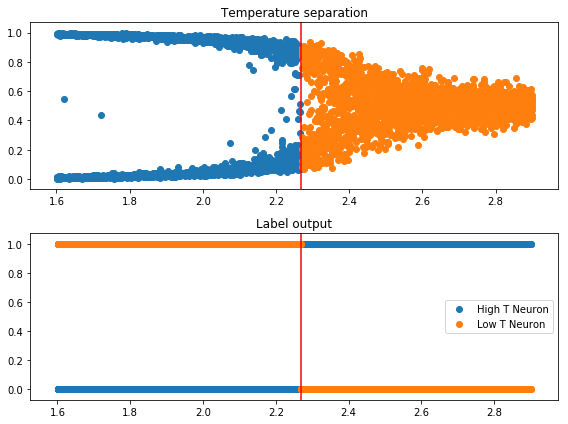

In [55]:
#Cambiando las labels a temperatura. La idea es que todo antes de la temperatura crítica sea por ejemplo [1,0] y
#todo por encima [0,1]. De nuevo usamos newT, newD y newM

#represents two output neurons [1,0] means ober critical T and [0,1] means under critical T
#holds all the labels
labels_T=np.zeros((len(temp),2)) 

#asigns label with respect to critical temperature
def T_labels(Ma,Te,crit,labels):
    T=np.array(Te)
    M = np.array(Ma)
    ii= T< crit
    jj = T>=crit
    #under Tc
    labels[ii,:]=[0,1]
    labels[jj,:]=[1,0]
    return T[ii], M[ii], T[jj], M[jj]
    
Tc=2.2691853

T_small, M_small, T_big, M_big = T_labels(M, temp, Tc,labels_T)

#plt.scatter(T_less,M_less)
#plt.scatter(T_big, M_big)
#plt.axvline(x=Tc, color='red')

fig, subp=plt.subplots(2,1,figsize=(8,6)) #crea 2 subplots en una columna
#fig es la entidad figura y subp es un array que en cada posicion guarda el subplot
#subp se puede manipular como un array para modificar individualmente los subplots
subp[0].scatter(T_small,M_small)
subp[0].scatter(T_big, M_big)
subp[0].set_title('Temperature separation')
subp[0].axvline(x=Tc, color='red')
subp[1].scatter(temp,labels_T[:,0], label='High T Neuron')
subp[1].scatter(temp,labels_T[:,1], label='Low T Neuron')
subp[1].set_title('Label output')
subp[1].legend()
subp[1].axvline(x=Tc, color='red')
subp
fig.tight_layout() #ajusta la distancia entre plots


In [56]:
data = pd.DataFrame(data)
temp = pd.DataFrame(temp,columns=['T'])
data_withT = pd.concat([data,temp],axis=1)


In [57]:
#creates a train test split delete if you have another data set
X_trainT, X_testT, y_train, y_test = train_test_split(data_withT,labels_T,test_size=0.3,random_state=101)

In [58]:
X_train=X_trainT.drop('T', axis=1)
X_test = X_testT.drop('T', axis=1)

In [59]:
#initializes weights
def weig(shape):
    first= tf.random_normal(shape,stddev=0.2)
    return tf.Variable(first)

#initializes bias
def bi(shape):
    first = tf.constant(np.random.rand(), shape=shape)
    return tf.Variable(first)

#defines the output function of each neuron in the layer
def layers(x, W,b):
  return tf.nn.sigmoid(tf.matmul(x, W)+b)


In [60]:
#WITH REGULARIZATION
#IT takes a like 40 minutes to run 60k epochs and we obtain a train_accuracy of 0.96 and eval_acc of 0.93
#very, very good


n_labels=2 #there will be one output neuron for each label
hidden=50 #number of hidden units
size=n_spins #system size


#Now we create the model with the input vector and teacher vector. This is the input layer
x = tf.placeholder("float", shape=[None, size])
y = tf.placeholder("float", shape=[None, n_labels]) #teacher vector = label


#defining the hidden layer
W_1 = weig([size,hidden])
b_1 = bi([hidden])
lay_1 = layers(x, W_1,b_1)
#Output layer
W_2 = weig([hidden,n_labels])
b_2 = bi([n_labels])
y_hat=layers(lay_1, W_2,b_2) #our predicted value

#Defining the cost function
error = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat)

#adds an  regularization term to with a beta value
beta=0.002 #for L1
#beta =0.01 #for L2

#creates an l1 regularizer
l1_regularizer = tf.contrib.layers.l1_regularizer( scale=beta, scope=None)
weights = tf.trainable_variables() # all vars from the graph
reg_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)

#this one for l2
#error = tf.reduce_mean(error + beta *( tf.nn.l2_loss(W_1)+tf.nn.l2_loss(W_2)))

#this one for l1
error = tf.reduce_mean(error + reg_penalty)

#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
optimizer = tf.train.AdamOptimizer(0.001)
train = optimizer.minimize(error)


#predictions
correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


In [61]:
saver2= tf.train.Saver()

In [62]:
#TRAINING the NN
#Variable outputs used to access data from the session tensors 
out=np.zeros(shape=(len(temp),n_labels))
outav=np.zeros(shape=(len(temp)))
outac = np.zeros(shape=(len(temp)))
evolve_acc = []

#starting a session 
init = tf.global_variables_initializer()
with tf.Session() as sess:
    
    sess.run(init)
    
    epochs = 7000
    #training cycle
    
    for i in range(epochs):
        train_accuracy = sess.run(accuracy,feed_dict={ x:X_train, y: y_train})      
        sess.run(train,feed_dict={x:X_train, y:y_train})#feeding data to the place holders 
        #stops training when accuracy crosses a certain threshold
        if i%50 == 0:
            evolve_acc.append(train_accuracy)
            print ("step %d, training accuracy %g"%(i, train_accuracy))
        if(train_accuracy>=0.98):
            print(train_accuracy)
            print(i)
            break;
    print("Accuracy:", train_accuracy)

    
    #now let's try checking the neuron outputs for each temperature
    out=(sess.run(y_hat,feed_dict={x:X_train, y:y_train}))
    for i in range(len(temp)):
        res=sess.run(y_hat,feed_dict={x: X_train, y: y_train})
        
    outav=res #neuron outputs
    
    saver2.save(sess, 'ising2.ckpt')

step 0, training accuracy 0.448447
step 50, training accuracy 0.659006
step 100, training accuracy 0.779814
step 150, training accuracy 0.830435
step 200, training accuracy 0.791925
step 250, training accuracy 0.695031
step 300, training accuracy 0.7
step 350, training accuracy 0.693789
step 400, training accuracy 0.68354
step 450, training accuracy 0.66646
step 500, training accuracy 0.648447
step 550, training accuracy 0.643478
step 600, training accuracy 0.632609
step 650, training accuracy 0.648758
step 700, training accuracy 0.663354
step 750, training accuracy 0.686957
step 800, training accuracy 0.702174
step 850, training accuracy 0.709317
step 900, training accuracy 0.714286
step 950, training accuracy 0.717702
step 1000, training accuracy 0.719565
step 1050, training accuracy 0.719876
step 1100, training accuracy 0.721429
step 1150, training accuracy 0.72236
step 1200, training accuracy 0.723292
step 1250, training accuracy 0.723913
step 1300, training accuracy 0.723913
step 

In [63]:
#Loads test data
#with open('spins_COP_test.p', 'rb') as f:
#    test_D = pickle.load(f)
#with open('temperatures_COP_test.p', 'rb') as f:
#    test_T = pickle.load(f)

In [64]:
#test_config=np.shape(test_D)[0]
#test_spins=len(test_D[0,:])

#print(test_config)
#print(test_spins)

#test_M=[] #stores the total (scaled) magnetization of each configuration in terms of temperature

#calculates magnetization for each configuration
#for i in range(0,n_config):
#    m=0
#    m=np.sum(test_D[i,:])/n_spins  
#    test_M.append(m)

#represents two output neurons [1,0] means ober critical T and [0,1] means under critical T
#labels_test=np.zeros((len(test_T),2)) 

#T_small2, M_small2, T_big2, M_big2 = T_labels(test_M, test_T, Tc,labels_test)

In [65]:
#evaluates the trained network with the new unlabeled data
with tf.Session() as sess:
    #restores the model
    saver2.restore(sess, 'ising2.ckpt')
    for i in range(len(y_test)):
        output= sess.run(y_hat,feed_dict={x:X_test})
    print('evaluation accuracy=',  accuracy.eval({ x: X_test, y:y_test}))

    h_w, o_w= sess.run([W_1,W_2],feed_dict={x:X_test})




INFO:tensorflow:Restoring parameters from ising2.ckpt
evaluation accuracy= 0.9521739


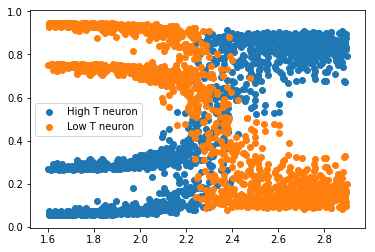

In [66]:
x=X_testT['T']
plt.scatter(x, output[:,0], label= 'High T neuron')
plt.scatter(x, output[:,1], label= 'Low T neuron')
plt.legend()
plt.savefig('eval_performance_50.pdf')


In [67]:
weigth_out=pd.DataFrame(h_w)
weigth_out.to_csv('W_50.csv')

out_out=pd.DataFrame(o_w)
out_out.to_csv('O_50.csv')


In [68]:
#Funny thing is that trainig acc varies but evaluation acc stays pretty much the same#Funny thing is that trainig acc varies but evaluation acc stays pretty much the same
acc_out=pd.DataFrame(evolve_acc)
acc_out.to_csv('acc_cross_entropy_50.csv')